In [1]:
from pandas import DataFrame, concat
from gensim.models import KeyedVectors, Word2Vec
from pathlib import Path
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, make_scorer, f1_score, precision_score
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
from gensim import corpora, models
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from pylab import get_cmap
import seaborn

from os import path, makedirs
from itertools import combinations
from re import sub, compile

import pickle
from scipy import stats
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Using TensorFlow backend.


In [2]:
DVACH = '2ch'
REDDIT = 'reddit'
MTS = 'mts'

DATA = REDDIT
COMMENT = 'comment'
if DATA == REDDIT:
    LANG = 'en'
else:
    LANG = 'ru'

In [3]:
from vectorizer import Vectorizer
vc = Vectorizer(LANG)

In [4]:
if not path.exists('figures'):
    makedirs('figures')

In [5]:
def set_plt_params():
    plt.figure(figsize=(3, 3))
    seaborn.set_style('whitegrid')
    plt.grid(False)

In [6]:
def train_lda_model(texts):
    texts = list(map(lambda text: vc.morph_sentence(text), texts))
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    lda = models.LdaModel(corpus, id2word=dictionary, num_topics=1)
    return lda

def get_lda_topics(lda, num_topics):
    r = compile(r'\W+')
    return [[sub(r, '', word.split('*')[1]) for word in topic[1].split(' + ')] 
          for topic in lda.print_topics(num_topics)][0]

In [7]:
UNKNOWN_CLASS = 'UNKNOWN'
texts = np.array([])
y = []
references = []

for class_id, name in enumerate([x for x in range(10)]):
        df = DataFrame.from_csv(path.join('{}-topics/'.format(DATA), '{}.csv'.format(name)))
        temp_texts = vc.make_vectors(df[COMMENT].values)
        y += [class_id]*len(temp_texts)
        if not texts.any():
            texts = temp_texts
        else:
            texts = np.vstack((texts, temp_texts))
        ldam = train_lda_model(df[COMMENT].values)
        references.append(' '.join(get_lda_topics(ldam, 1)))
        
references = vc.make_vectors(references)
X_train, X_test, y_train, _ = train_test_split(texts, y, test_size=0.1, random_state=42)

df_an = DataFrame.from_csv(path.join('{}-topics/'.format(DATA), '{}.csv'.format(UNKNOWN_CLASS)))
X_outliers = vc.make_vectors(df_an[COMMENT].values)
X_test = X_test[:len(X_outliers)]

In [8]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500)
regs = tsne_model.fit_transform(np.vstack([X_train,
                                           X_test,
                                           X_outliers]))

In [9]:
RANGE = 23
DOT_SIZE = 2

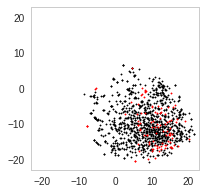

In [10]:
set_plt_params()

for i in regs[:len(X_train)+len(X_test)]:
    plt.scatter(i[0],i[1],color='black', s=DOT_SIZE)
    
for i in regs[len(X_train)+len(X_test):]:
    plt.scatter(i[0],i[1],color='red', s=DOT_SIZE)
    
plt.xlim(-RANGE, RANGE)
plt.ylim(-RANGE, RANGE)
plt.plot()
plt.savefig(path.join('figures', 'anomals.png'))
plt.show()

In [11]:
class StdThresholdClassifier():
    def __init__(self, train, threshold=0.23, clf=LogisticRegression(C = 9)):
        self._clf = clf
        self._threshold = threshold
        self._train = train
        
    def fit(self, X_train):
         self._clf.fit(X_train, self._train)
            
    def predict(self, X):
        return [1 if np.std(probs) < self._threshold else -1 for probs in self._clf.predict_proba(X)]

In [12]:
class CosineThresholdClassifier():
    def __init__(self, threshold=0.5):
        self._threshold = threshold
                 
    def _count_cosine(self, vector):
        distances = [1 - cosine(vector, reference) for reference in references]
        if all(distances) < self._threshold:
            return -1
        else:
            return 1
        
    def fit(self, X_train):
         pass
            
    def predict(self, X):
        return [self._count_cosine(vector) for vector in X]

In [13]:
class Autoencoder():
    def __init__(self, threshold=0.0004,  nb_epoch=50, encoding_dim=14, batch_size=32):
        self._input_dim = 0
        self._encoding_dim = encoding_dim
        self._nb_epoch = nb_epoch
        self._batch_size = batch_size
        self._threshold = threshold
        
    def fit(self, X):
        X_train, X_test = train_test_split(X, test_size=0.1)
        self._input_dim = X_train.shape[1]
        input_layer = Input(shape=(self._input_dim, ))
        encoder = Dense(self._encoding_dim, activation='tanh', 
                        activity_regularizer=regularizers.l1(10e-5))(input_layer)
        encoder = Dense(int(self._encoding_dim / 2), activation='relu')(encoder)
        decoder = Dense(int(self._encoding_dim / 2), activation='tanh')(encoder)
        decoder = Dense(self._input_dim, activation='relu')(decoder)
        autoencoder = Model(inputs=input_layer, outputs=decoder)
        autoencoder.compile(optimizer='adam', 
                            loss='mean_squared_error', 
                            metrics=['accuracy'])
        checkpointer = ModelCheckpoint(filepath='model.h5',
                                       verbose=0,
                                       save_best_only=True)
        tensorboard = TensorBoard(log_dir='./logs',
                                  histogram_freq=0,
                                  write_graph=True,
                                  write_images=True)
        history = autoencoder.fit(X_train, X_train,
                            epochs=self._nb_epoch,
                            batch_size=self._batch_size,
                            shuffle=True,
                            validation_data=(X_test, X_test),
                            verbose=0,
                            callbacks=[checkpointer, tensorboard]).history
        self._autoencoder = load_model('model.h5')
    

    def predict(self, X_test):
        predictions = self._autoencoder.predict(X_test)
        mse = np.mean(np.power(X_test - predictions, 2), axis=1)
        return [1 if x < self._threshold else -1 for x in mse]

In [14]:
for classifier_name, classifier in [
                    ('OneClassSVM', OneClassSVM(kernel='poly', nu=1e-4, gamma=1e-4)), 
                    ('IsolationForest', IsolationForest(n_estimators=10, bootstrap=False,random_state=0)),
                    #('EllipticEnvelope', EllipticEnvelope(contamination=0.5, assume_centered=False, support_fraction=0.5)),
                    ('LocalOutlierFactor', LocalOutlierFactor(n_neighbors=1, metric='cosine', algorithm='brute')),
                    ('STDThreshold', StdThresholdClassifier(y_train, 0.2, LogisticRegression(C = 9))),
                    ('CosineThreshold', CosineThresholdClassifier(0.3)),
                    ('Autoencoder', Autoencoder(0.2, 50, 10, 10))
                    ]:
    clf = classifier
    if classifier_name == 'LocalOutlierFactor':
        y = clf.fit_predict(np.r_[X_train, X_test, X_outliers])
        y_pred_train = y[:len(X_train)]
        y_pred_test = y[len(X_train):len(X_train) + len(X_test)]
        y_pred_outliers = y[len(X_train) + len(X_test):]
    elif classifier_name == 'Autoencoder':
        clf.fit(X_train)
        y_pred_train = clf.predict(np.array(X_train))
        y_pred_test = clf.predict(np.array(X_test))
        y_pred_outliers = clf.predict(np.array(X_outliers))
    else:
        clf.fit(X_train)
        y_pred_train = clf.predict(np.array(X_train))
        y_pred_test = clf.predict(np.array(X_test))
        y_pred_outliers = clf.predict(np.array(X_outliers))

    print(classifier_name)
    print('Accuracy on test={:0.2f}, on anomals={:0.2f}, overall={:0.2f}'.format(
        accuracy_score(y_pred_test, np.negative(np.ones(shape=len(X_test)))),
        accuracy_score(y_pred_outliers, np.ones(shape=len(y_pred_outliers))),
        accuracy_score(np.hstack([y_pred_test, y_pred_outliers]),
        np.hstack([np.negative(np.ones(shape=len(X_test))), 
                                   np.ones(shape=len(X_outliers))]))))
    set_plt_params()
    print()
    [plt.scatter(i[0],i[1],color='black',s=DOT_SIZE) if y_pred_train[ind] == 1 else 
     plt.scatter(i[0],i[1],color='red', s=DOT_SIZE) for ind, i in enumerate(regs[:len(X_train)])]
    [plt.scatter(i[0],i[1],color='black', s=DOT_SIZE) if y_pred_test[ind] == 1 else 
     plt.scatter(i[0],i[1],color='red', s=DOT_SIZE) for ind, i in enumerate(regs[len(X_train):len(X_train)+len(X_test)])]
    [plt.scatter(i[0],i[1],color='black', s=DOT_SIZE) if y_pred_outliers[ind] == 1 else 
     plt.scatter(i[0],i[1],color='red', s=DOT_SIZE) for ind, i in enumerate(regs[len(X_train)+len(X_test):])]
    plt.xlim(-RANGE, RANGE)
    plt.ylim(-RANGE, RANGE)
    plt.plot()
    plt.savefig(path.join('figures', 'anomaly_on_{}.png').format(classifier_name.lower()))

OneClassSVM
Accuracy on test=1.00, on anomals=0.00, overall=0.50

IsolationForest
Accuracy on test=0.10, on anomals=0.85, overall=0.47

LocalOutlierFactor
Accuracy on test=0.08, on anomals=0.87, overall=0.47

STDThreshold
Accuracy on test=0.53, on anomals=0.82, overall=0.68

CosineThreshold
Accuracy on test=0.00, on anomals=1.00, overall=0.50

Autoencoder
Accuracy on test=0.00, on anomals=1.00, overall=0.50



In [16]:
for classifier_name, classifier in [
                    ('OneClassSVM', OneClassSVM(kernel='linear', nu=0.9, gamma=100)), 
                    ('IsolationForest', IsolationForest(n_estimators=60, bootstrap=True,random_state=0)),
                    #('EllipticEnvelope', EllipticEnvelope(contamination=0.5, assume_centered=True, support_fraction=0.5)),
                    ('LocalOutlierFactor', LocalOutlierFactor(n_neighbors=1, metric='cosine', algorithm='brute')),
                    ('STDThreshold', StdThresholdClassifier(y_train, 0.15, LogisticRegression(C = 9))),
                    ('CosineThreshold', CosineThresholdClassifier(0.2)),
                    ('Autoencoder', Autoencoder(0.0088, 50, 50, 20))
                    ]:
    clf = classifier
    if classifier_name == 'LocalOutlierFactor':
        y = clf.fit_predict(np.r_[X_train, X_test, X_outliers])
        y_pred_train = y[:len(X_train)]
        y_pred_test = y[len(X_train):len(X_train) + len(X_test)]
        y_pred_outliers = y[len(X_train) + len(X_test):]
    else:
        clf.fit(X_train)
        y_pred_train = clf.predict(np.array(X_train))
        y_pred_test = clf.predict(np.array(X_test))
        y_pred_outliers = clf.predict(np.array(X_outliers))

    print(classifier_name)
    print('Accuracy on test={:0.2f}, on anomals={:0.2f}, overall={:0.2f}'.format(
        accuracy_score(y_pred_test, np.negative(np.ones(shape=len(X_test)))),
        accuracy_score(y_pred_outliers, np.ones(shape=len(y_pred_outliers))),
        accuracy_score(np.hstack([y_pred_test, y_pred_outliers]),
        np.hstack([np.negative(np.ones(shape=len(X_test))), 
                                   np.ones(shape=len(X_outliers))]))))
    set_plt_params()
    print()
    [plt.scatter(i[0],i[1],color='black',s=DOT_SIZE) if y_pred_train[ind] == 1 else 
     plt.scatter(i[0],i[1],color='red', s=DOT_SIZE) for ind, i in enumerate(regs[:len(X_train)])]
    [plt.scatter(i[0],i[1],color='black', s=DOT_SIZE) if y_pred_test[ind] == 1 else 
     plt.scatter(i[0],i[1],color='red', s=DOT_SIZE) for ind, i in enumerate(regs[len(X_train):len(X_train)+len(X_test)])]
    [plt.scatter(i[0],i[1],color='black', s=DOT_SIZE) if y_pred_outliers[ind] == 1 else 
     plt.scatter(i[0],i[1],color='red', s=DOT_SIZE) for ind, i in enumerate(regs[len(X_train)+len(X_test):])]
    plt.xlim(-RANGE, RANGE)
    plt.ylim(-RANGE, RANGE)
    plt.plot()
    plt.savefig(path.join('figures', 'anomaly_on_{}.png').format(classifier_name.lower()))


OneClassSVM
Accuracy on test=0.87, on anomals=0.19, overall=0.53

IsolationForest
Accuracy on test=0.08, on anomals=0.86, overall=0.47

LocalOutlierFactor
Accuracy on test=0.08, on anomals=0.87, overall=0.47

STDThreshold
Accuracy on test=0.82, on anomals=0.60, overall=0.71

CosineThreshold
Accuracy on test=0.00, on anomals=1.00, overall=0.50

Autoencoder
Accuracy on test=0.02, on anomals=0.98, overall=0.50



In [ ]:
gamma_range = np.arange(0.5, 5, 0.1)
nu_range = np.arange(1e-2, 0.3, 1e-2)

tuned_parameters = [{'kernel': ['rbf'], 'gamma':  gamma_range,
                    'nu': nu_range},
                   ]

clf = GridSearchCV(OneClassSVM(), tuned_parameters, 
                    scoring=(lambda estimator, train_set, target_set: 
                    accuracy_score(estimator.fit(train_set).predict(texts_reg_test + 
                                                                   texts_anomal), 
                    np.hstack([np.negative(np.ones(shape=len(texts_reg_test))), 
                               np.ones(shape=len(texts_anomal))]))))

print('Grid scores:')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print('{:0.3f} (+/-{:0.03f} for {})'.format(mean, std*2, params))

In [ ]:
scores = clf.cv_results_['mean_test_score'].reshape(len(nu_range), 
                                                       len(gamma_range))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=get_cmap("Spectral"),
           norm=MidpointNormalize(vmin=0.5, midpoint=0.6))
plt.xlabel('gamma')
plt.ylabel('nu')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(nu_range)), nu_range)
#plt.title('Gridsearch Heatmap on RBF Kernel')
plt.show()